## Fourier Transform and Blurring

In this notebook, the relationship between Fourier transforms and blurring will be analysed. In the previous notebook (Gaussian Blur), it was stated that the blurring kernels (or convolution matrices) perform what is known as a "low pass filtering". In the context of signal processing, an ideal low pass filter is a linear filter which removes the high frequencies from the signal, i.e forcing a bandlimit (or frequency limit) on the spectrum of a signal by removing the high  frequencies. For example, given a time domain signal $s(t)$, low pass filtering this signal with threshold $\Omega$ is the equivalent to multiplying the fourier transform of $s(t)$ by a 1-pulse of width $2\Omega$.

Generalising the idea aforementioned, a Gaussian Blur kernel would remove high frequencies of an image, or equivalently, removing aspects such as hard edges and smoothing boundaries. With this in mind, a common method for checking the focus of an image, or the blur degree, is to analyse the fourier transform and compare the energy of high frequencies relative to lower frequencies. Defining the line between high frequencies and low frequencies can be difficult and domain specific, hence the Laplacian will also be incorporated in this method to make this process a little bit less domain-dependent.


### Laplacian 

In order to define the Laplacian, consider a scaar function $f(x_1,x_2,\dots,x_n)$. The gradient vector field of $f$ (or grad), $\nabla f(x_1,x_2,\dots,x_n)$, is defined as

$$
\nabla f(x_1,x_2,\dots,x_n) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n} 
\end{bmatrix}
$$

where $\nabla$ could simply be described as a $(n\times n)$ column vector containing all the partial derivative operators. The Laplace operator, $\nabla^2$ or $\nabla \cdot \nabla$, is defined to be the divergence of the gradient. The Laplacian is then formulated as 

$$
\nabla^2 f(x_1,x_2,\dots,x_n) = \frac{\partial^2 f}{\partial x_1^2} + \dots + \frac{\partial^2 f}{\partial x_n^2}
$$

where it measures the change of the function in the n-dimensional case. In the one dimensional case, the Laplacian simply measures the second derivative of a function. In this context, the laplacian measures the quantity of change in the derivative of the function. Therefore, the points where the function has rapidly changing values, the Laplacian would return a high value, and a low value for points where changes are small, it would return a low value (close to 0).

In the context of image processing, the Laplacian can be approximated with the matrix $L$ where

$$
L =
\begin{bmatrix}
0 && 1 && 0 \\
1 && -4 && 0 \\
0 && 1 && 0 \\
\end{bmatrix}
$$

and this kernel can be convoluted with images in order to find where the colour changes are happening. The Laplacian filter will be used to find where fast changes are happening in the image. The variance of the Laplacian of the image will then be calculated, and there will be two possible outcomes: 

- Variance can be high, meaning that there are huge variations in intensity changes in the image. This implies that the edges are fairly sharp and hence not very blurry.
- Variance can be low, meaning there are not hige variantions in intensity changes. This implies that the edges are not sharp and hence blurry.

The next cells will provide code to calculate the Laplacian of a test image and compare the variance of the Laplacian of the normal image with the blurry image.

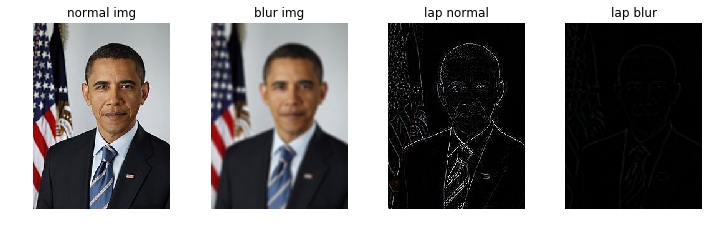

In [1]:
%matplotlib inline
import numpy as np
import filtering as fil
import utilities as ut
from matplotlib import pyplot as plt

# Laplacian Kernel
laplacian = np.array(([0,1,0],[1,-4,1],[0,1,0]))

# Blurring kernel
gauss = fil.gaussian_kernel(7, [0,0], 6)

# Open the image
img_normal = ut.read_image("test.jpg")
img_blur = fil.image_conv(img_normal, gauss)

# Get both laplacians
lp_normal = fil.image_conv(img_normal, laplacian)
lp_blur = fil.image_conv(img_blur, laplacian)

####  Plotting Code Below 
def plot_grid(rows, cols, pos, img, title):
    """
    Function to plot image in a grid.
    """
    ax = plt.subplot(rows,cols,pos)
    ax.set_axis_off() 
    ax.set_title(title)
    ax.imshow(img)
    
# Plotting each image here
fig = plt.figure(figsize=(10,5))
plot_grid(1, 4, 1, img_normal, "normal img")
plot_grid(1, 4, 2, img_blur, "blur img")
plot_grid(1, 4, 3, lp_normal, "lap normal")
plot_grid(1, 4, 4, lp_blur, "lap blur")
fig.tight_layout(); plt.show()

In [2]:
# Comparing the variance of each of them
normal_var = np.var(lp_normal)
blur_var = np.var(lp_blur)

print("Normal image's Laplace variance: %.3f" % normal_var)
print("Blurred image's Laplace variance: %.3f" % blur_var)

Normal image's Laplace variance: 722.683
Blurred image's Laplace variance: 8.324


### Comparing the Fourier of Blurred and Unblurred Images

The next cell will use OpenCV to calculate the Fourier transform of the images loaded in the cell above. In this case, OpenCV's FFT function will be used to calculate the fourier of both normal and blurred images. For more information on the calculation of the fourier, see the ** analysis.py ** file and the documentation.

From the amplitude spectrum, it should be clear from the plots below that the blurred images contains less energy on the higher frequencies, wheras the normal, sharp image has energy even in very high frequencies.

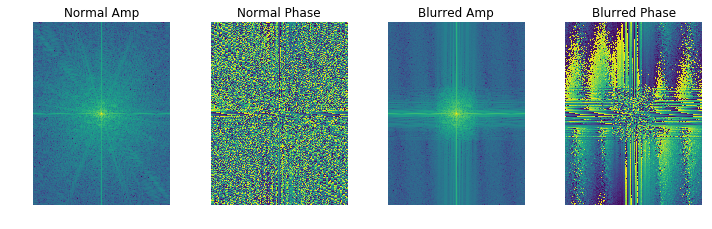

In [3]:
from analysis import fourier
import cv2

# Function to calculate spectra
def calc_spectra(img_grey):
    """
    This function will calculate both 
    the amplitude and phase spectra 
    of an image (returns tuple).
    
    img_grey - grayscale image
    """
    
    # Uses fourier function from analysis.py
    return fourier(img_grey)

# Get the grayscale images to get FFT
fft_img_normal = ut.convert_spaces(img_normal, "RGB2GRAY")
fft_img_blur = ut.convert_spaces(img_blur, "RGB2GRAY")

# Get the spectra for both images
amp_normal, phase_normal = calc_spectra(fft_img_normal)
amp_blur, phase_blur = calc_spectra(fft_img_blur)


## Plotting code here
images = [amp_normal, phase_normal, amp_blur, phase_blur]
names = ["Normal Amp", "Normal Phase", "Blurred Amp", "Blurred Phase"]
fig = plt.figure(figsize=(10, 5))# Usual Size
for i in range(4): plot_grid(1, 4, i+1, images[i], names[i])
fig.tight_layout(); plt.show()

It is obvious from the amplitude spectrum - which essentially represets how much energy there is in a frequency -- that the blured image contains less energy at high frequencies, which are away from the center frequency. The reason for this is, since the Gaussian blur kernel represents a low pass filter, the high frequencies are weakened by the filtering process. The phase spectrum of a signal/image represents the offset of each frequency in the image, so it is not considered for the purposes of this method.


### Using the Fourier to Calculate Degree of Blur

Given the analysis presented above, a method for calculating the amount of blur can be derived. Firtly, given that for a function $f(t)$ such that $|f(0)|>f(t)$ for $t$, the equivalent rectangle resolution (ERR) $\tau$, is defined to be

$$
\tau = \frac{E_f}{|f(0)|^2}
$$

where $E_f$ represents the squared energy of $f(t)$. Rearranging the formula above tells us that the energy of $f(t)$ can be contained in a rectangle of width $\tau$ and height $|f(0)|^2$. Therefore, since the amplitude Fourier transform of an image satisfies the condition $|f(0)|>f(t)$, where $f(0)$ represents the energy at the $0^{th}$ frequency which is in the middle, it is possible to calculate the ERR of the fourier. The outcome can be the following:

* $\tau$ is small, meaning that the energy area is contained within a small width. This implies that the high frequencies do not contain much energy, so they are not relevant and the image is blurred.
* $\tau$ is large, meaning that the energy area is contained within a large width. This implies that the high frequencies contain reasonable amounts of energy and image is probably sharp as high frequencies are present.

The next cell will compare the ERR of the normal image with the blurred image. The expected result would be a higher ERR for the normal image.

In [4]:
# Calculate both energies (from the amplitude)
energy_normal = np.sum(amp_normal*amp_normal)
energy_blur = np.sum(amp_blur*amp_blur)

# Get the f(0) of both amplitudes (Note its max)
f_normal = np.max(amp_normal)
f_blur = np.max(amp_blur)

# Now calculate the ERR for both
err_normal = energy_normal/f_normal
err_blur = energy_blur/f_blur

# Just print them
print("The ERR of the normal image is: %.2f" % err_normal)
print("The ERR of the blurred image is: %.2f" % err_blur)
print("The difference of the ERR is %.2f" % (err_normal-err_blur))

The ERR of the normal image is: 5265562.50
The ERR of the blurred image is: 3047601.00
The difference of the ERR is 2217961.50


From calculating the difference between the ERRs above, it can be seen that the normal image's amplitude is roughly twice bigger than the blurred ERR. 

#### Algorithm for Blur Detection

In order to fix the focus blur of images in a dataset, the methods presented above can be used. The ERR will be used to detect how blurred a picture is, and the variance of the Laplacian will be used equalise the Fourier spectrum of the image according to the level of blur. Note that the inverse of blurring (low pass filters) are high pass filters, or sharpening filters. Unfortunately, high pass filters will not only amplify the high frequencies, but they also amplify the noise, hence other forms of blurring correction might be considered at a later stage of the project.


The next cell will contain code to fix an image's sharpness. The outline of the algorithm is given by the following pseudo-code

    # Rough logic for how image is being sharpened
    tau := get the ERR of image
    
    if tau > threshold:
        lp := get the laplacian of image
        equalise spectrum using lp
    else:  # No blurr detected.
        return image

In [5]:
import analysis as an

# Read the original image
image = ut.read_image("test.jpg")

# Make a blurred version out of the image above
kernel_gauss = fil.gaussian_kernel(7, [0,0], 12)
image_blur = fil.image_conv(image, kernel_gauss)

# Greyscale images for the fourier analysis
normal_grey = ut.convert_spaces(image, "RGB2GRAY")
blur_grey = ut.convert_spaces(image_blur, "RGB2GRAY")

# Get both ERR (for now use the normal as the threshold)
tau_t = an.get_err(normal_grey)
tau = an.get_err(blur_grey)
    
# Mock logic for how to reconstruct the sharp image
if tau < tau_t:
    
    # For now, use the variance of the normal
    # laplacian as our blurring degree threhold
    var_lp_t = np.var(an.get_laplacian(normal_grey))
    
    # Get the Laplacian of the blurred
    var_lp = np.var(an.get_laplacian(blur_grey))
    
    # Get the degree of blurring
    degree = var_lp_t/var_lp
    print("Degree of blurring is %.2f" % degree)

Degree of blurring is 95.87


The cell above provide a way of finding how blurred an image is. In theory, in order to undo the blurring of a filter, a high pass filter must be applied to amplify the high frequencies. High pass filters do exactly the opposite of low pass filters - they amplify the high frequencies ina signal/image. Unfortunately, high pass filters also amplify the noise in an image, since low pass filters alleviate noise in signals. Therefore, a slightly different approach will be used in order to sharpen images and enhance the edges in an image.

### Unsharp Mask 

As mentioned above, high pass filters alone are not practical when sharpening an image, since they amplify the noise in images and do not keep the lowe frequencies. In order to keep the low frequencies of a signal, and minimise the noise in the process, the "unsharp" mask filter will be used. The term "unsharp" is used due to the method for amplifying the high frequencies - the (blurred) image is filterd using a suitable blurring filter, reducing the image's high frequencies even further, then subtracting a fraction of the over blurred image from the original image and. The idea behind this process is to gently average the image containing only the high frequencies with the unprocessed (blurred) image, emphasising the high frequencies slightly.

In terms of signal processing, the output of the system could be represented as the function $g(t)$, with the following formulation:

$$
\begin{align} 
g(t) &= \alpha f(t) - \beta \bigg[\frac{f(t-t_{-N})+f(t-t_{-N+1})+\dots+f(t)+f(t+t_{1})\dots f(t+t_{N})}{2N+1}\bigg] \\
&= \alpha f(t) - \beta \bigg[\frac{f(t) + \sum_{i=1}^{N} f(t-t_{-i}) + f(t+t_i)}{2N+1}\bigg]
\end{align}
$$

At first glance it seems like a complicated output, but the output system above is simply a weighted sum of the original image, $\alpha f(t)$, and a blurred (or low passed) version of the signal/image, $\beta [...]$. Note that, in the equation above, $N$ simply means the number of neighbouring samples to include in the average, giving an overall of $2N+1$ samples to consider.

Using the equation above for the output of the system, the inpulse response function (or the convoluting function/matrix) can be expressed as the following:

$$
h(t) = \alpha\delta(t) - \beta \bigg[\frac{\delta(t) + \sum_{i=1}^{N} \delta(t-t_{-i}) + \delta(t+t_i)}{2N+1}\bigg]
$$

but note that the second term of the equation above is simply a blurring/low pass filter. Hence, without loss of generality, in the image processing context the unsharp mask can be represented as the following filter: 

$$
\mathbf{U} = \alpha \mathbf{D_\delta} - \beta \mathbf{G}
$$

where $\mathbf{U}$ is the unsharp mask filter, $\mathbf{D_\delta}$ is the impulse matrix and $\mathbf{G}$ is a blurring/low pass matrix (for example, it could be the Gaussian Kernel used previously). In the method above, $\alpha$ and $\beta$ control how much sharpening must be done to the image, the type of sharpening is controlled by the blurring matrix $\mathbf{G}$. It is advisable that $\alpha-\beta=1$, to make sure all the intensities in the final processed image array have values in $range(0, 255)$.

The next cell will provide an implementation of the above concept. Note that, the output of the filter presented above may need saturation, as averaging the high passed image with the original will cause intensity to lower slightly. (Note: to see this, look at the high pass filters in the previous notebook, the processed image is mainly dark with very few details).

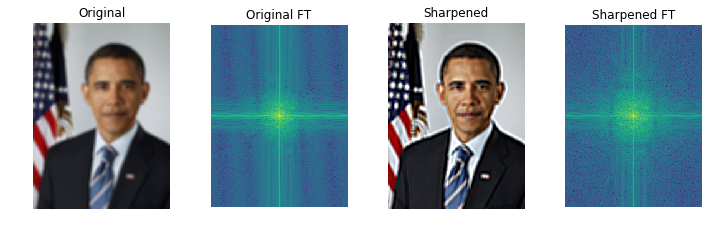

In [6]:
# Calculate our unsharp mask filter U
a, b = 5, 4 # a-b=1
gaussian_kernel = fil.gaussian_kernel(7, [0,0], 10) # low pass
unmask = a*fil.delta(7) - b*gaussian_kernel # U

# Apply unsharp mask filter to image by convolution
sharpened = fil.image_conv(image_blur, unmask)

# Calculate the amplitude spectra
ft_blur = an.fourier(ut.convert_spaces(image_blur, "RGB2GRAY"))[0]
ft_sharp = an.fourier(ut.convert_spaces(sharpened, "RGB2GRAY"))[0]

# Plotting the images (original, sharpened)
fig = plt.figure(figsize=(10, 5))
plot_grid(1,4,1, image_blur, "Original")
plot_grid(1,4,2, ft_blur, "Original FT")
plot_grid(1,4,3, sharpened, "Sharpened")
plot_grid(1,4,4, ft_sharp, "Sharpened FT")
fig.tight_layout()
plt.show()

It can be seen from analysing the amplitude FT spectrum above that the filter applied to the original blurred image amplified the frequencies away from the center (the high frequencies). Unfortunately, the amplitude spectrum of the sharpened image was not completely recovered (see amp spectrum of the normal image in the Fourier third cell), but the overall "sharpness" of the blurred image was improved, so edges are more easily distinguishable. 

The next cell will calculate the ERR of the both images (blurred and sharpened) and the variance of the Laplacian. Note that the plotting is done with the log of the values, so that both the variance of the Laplacian and the ERR can be plotted in the same graph, however, the difference in values is a lot larger than shown in the plotting. Both results are improved with the unsharp mask filter as it can be seen below.

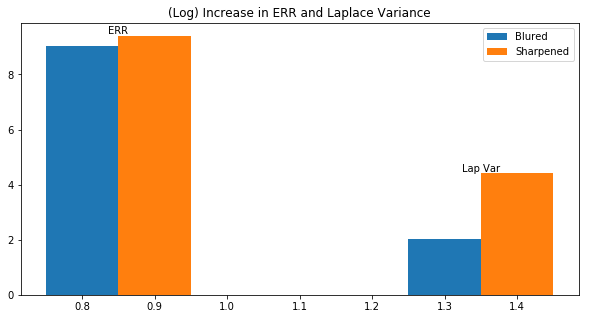

In [7]:
# Get greyscale images (for analysis)
sharp_grey = ut.convert_spaces(sharpened, "RGB2GRAY")
blur_grey = ut.convert_spaces(image_blur, "RGB2GRAY")

# Get both results
err_sharp = an.get_err(sharp_grey)
err_blur = an.get_err(blur_grey)
var_sharp = np.var(an.get_laplacian(sharp_grey))
var_blur = np.var(an.get_laplacian(blur_grey))

# Plotting the results 
fig, ax = plt.figure(figsize=(10,5)), plt.gca()

plot_blur = np.log([err_blur, var_blur])
plot_sharp  = np.log([err_sharp, var_sharp])
ax.set_title("(Log) Increase in ERR and Laplace Variance")
ax.bar([0.8,1.3], plot_blur, 0.1)
ax.bar([0.9, 1.4], plot_sharp, 0.1)

# Putting the label on the bars
ax.text(0.85, np.max(np.log([err_blur, err_sharp])),"ERR",ha='center', va='bottom')
ax.text(1.35, np.max(np.log([var_blur, var_sharp])),"Lap Var",ha='center', va='bottom')
ax.legend(("Blured", "Sharpened"))
plt.show();
